In [2]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
import math
import json

## Data Analysis on Primary

In [3]:
# set this to either primary or secondary depending on the analysis you want to do
dataset = 'primary'

mappings = json.load(open(f'../dataset/mapping_{dataset}.json'))
data = pd.read_csv(f'../dataset/mapped_{dataset}.csv')

In [4]:
# drop the uuid column as it isn't a guantitative value
data = data.select_dtypes(include=['number'])
print(data.describe())

              price        artist    cardFinish  colorIdentity        colors  \
count  15214.000000  15214.000000  15214.000000   15214.000000  15214.000000   
mean       1.274955    226.710661      1.664322      18.078020     18.300841   
std        1.687801    128.233722      0.542586       9.667796      9.662374   
min        0.010000      0.000000      0.000000       0.000000      0.000000   
25%        0.200000    114.000000      1.000000      12.000000     13.000000   
50%        0.490000    240.000000      2.000000      21.000000     21.000000   
75%        1.570000    340.000000      2.000000      27.000000     27.000000   
max        7.760000    441.000000      2.000000      30.000000     30.000000   

         edhrecRank  edhrecSaltiness  gameAvailability     isReprint  \
count  15214.000000     15214.000000      15214.000000  15214.000000   
mean    6407.912120         0.393107          0.817405      0.365124   
std     4896.242696         0.316997          0.386347      0.4

In [5]:
# plot function 
def plot(data, type, color=plt.cm.viridis(0.2), bins=None, lim=None, mapping_dict=None):
    """Creates plots for the quantitative DataFrame
    Args:
        - data: dataframe
        - type: type of plot (hist, box)
        - color: plot color
        - bins: number of bins in this hist
        - lim: optional bound for graph
    """
    # subplot calcuations for size
    num = len(data.columns)
    ncols = 2
    nrows = int(np.ceil(num / ncols))

    # size based on nrows
    plt.figure(figsize=(12, 5*nrows))

    for i, column in enumerate(data.columns):      
        plt.subplot(nrows,ncols,i+1)
        if type == "hist":
            plt.hist(data[column], color = color, bins=bins)
            plt.title(f"Histogram of {column}")
            plt.ylabel("Frequency")
            plt.xlabel("Value")
            if lim:
                plt.title(f"Histogram of {column} bounded under {lim}")
                plt.xlim(0,lim)

        elif type == "box":
            if bins == 2 and column != "price":
                sns.boxplot(x = column, y = "price", data = data)
                plt.ylabel("price")
            else:
                plt.boxplot(data[column], whis=lim, patch_artist=True)
                plt.ylabel("Value")
            plt.title(f"Box Plot of {column}")
            if lim:
                plt.ylim(0,lim)
    plt.show()

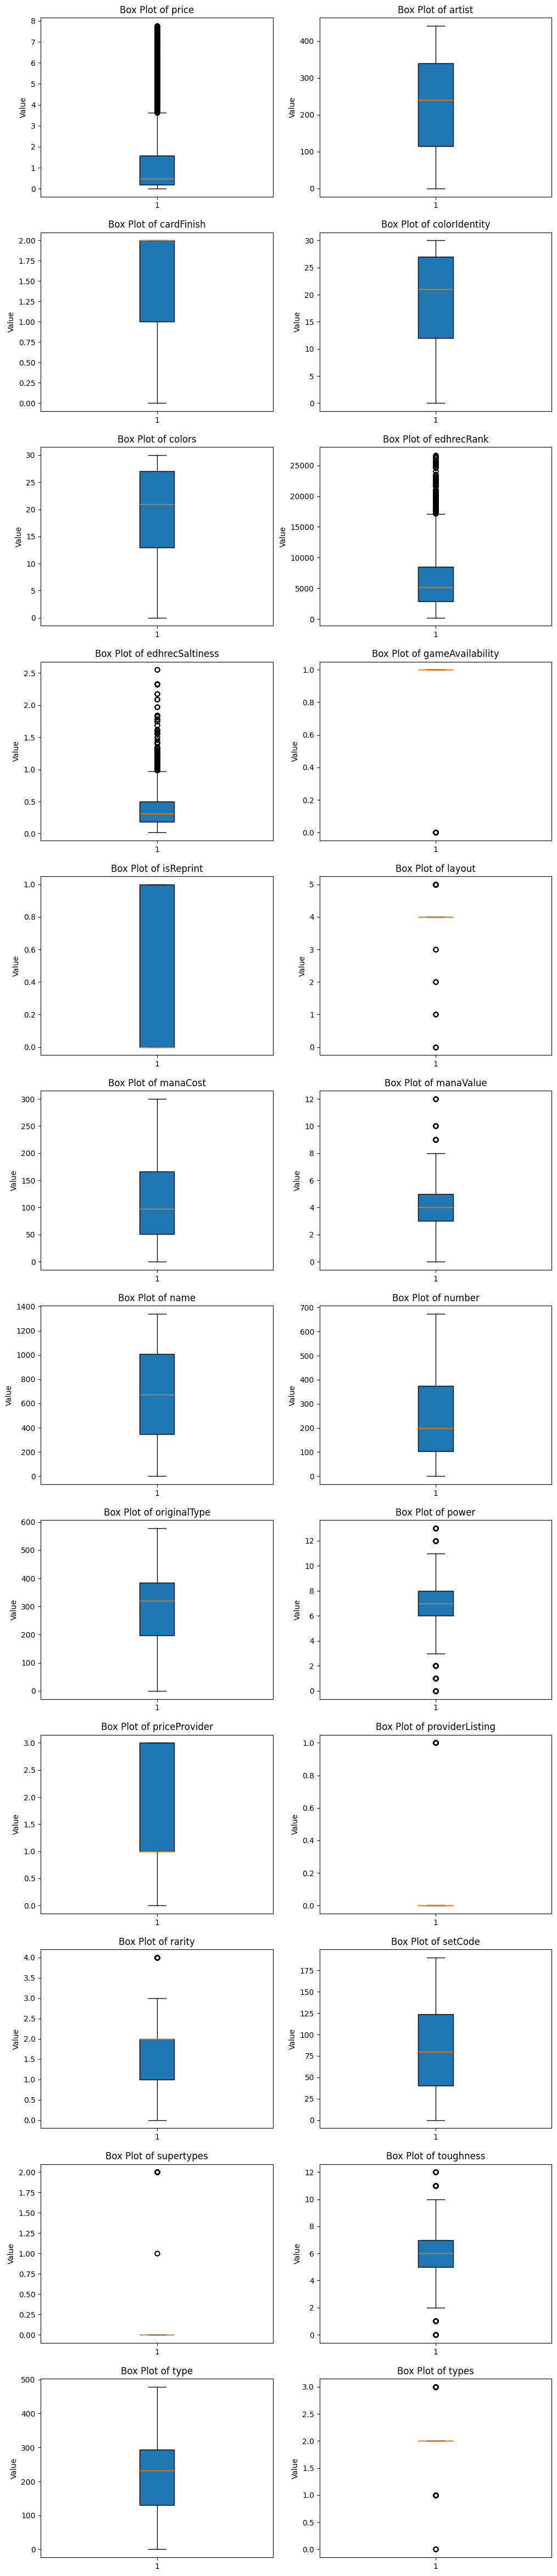

In [6]:
plot(data, "box")

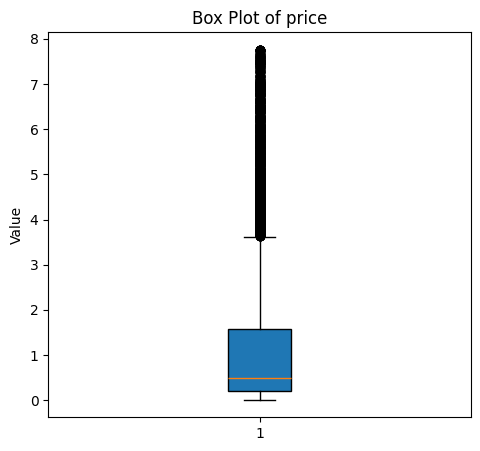

In [7]:
plot(data[["price"]], "box")

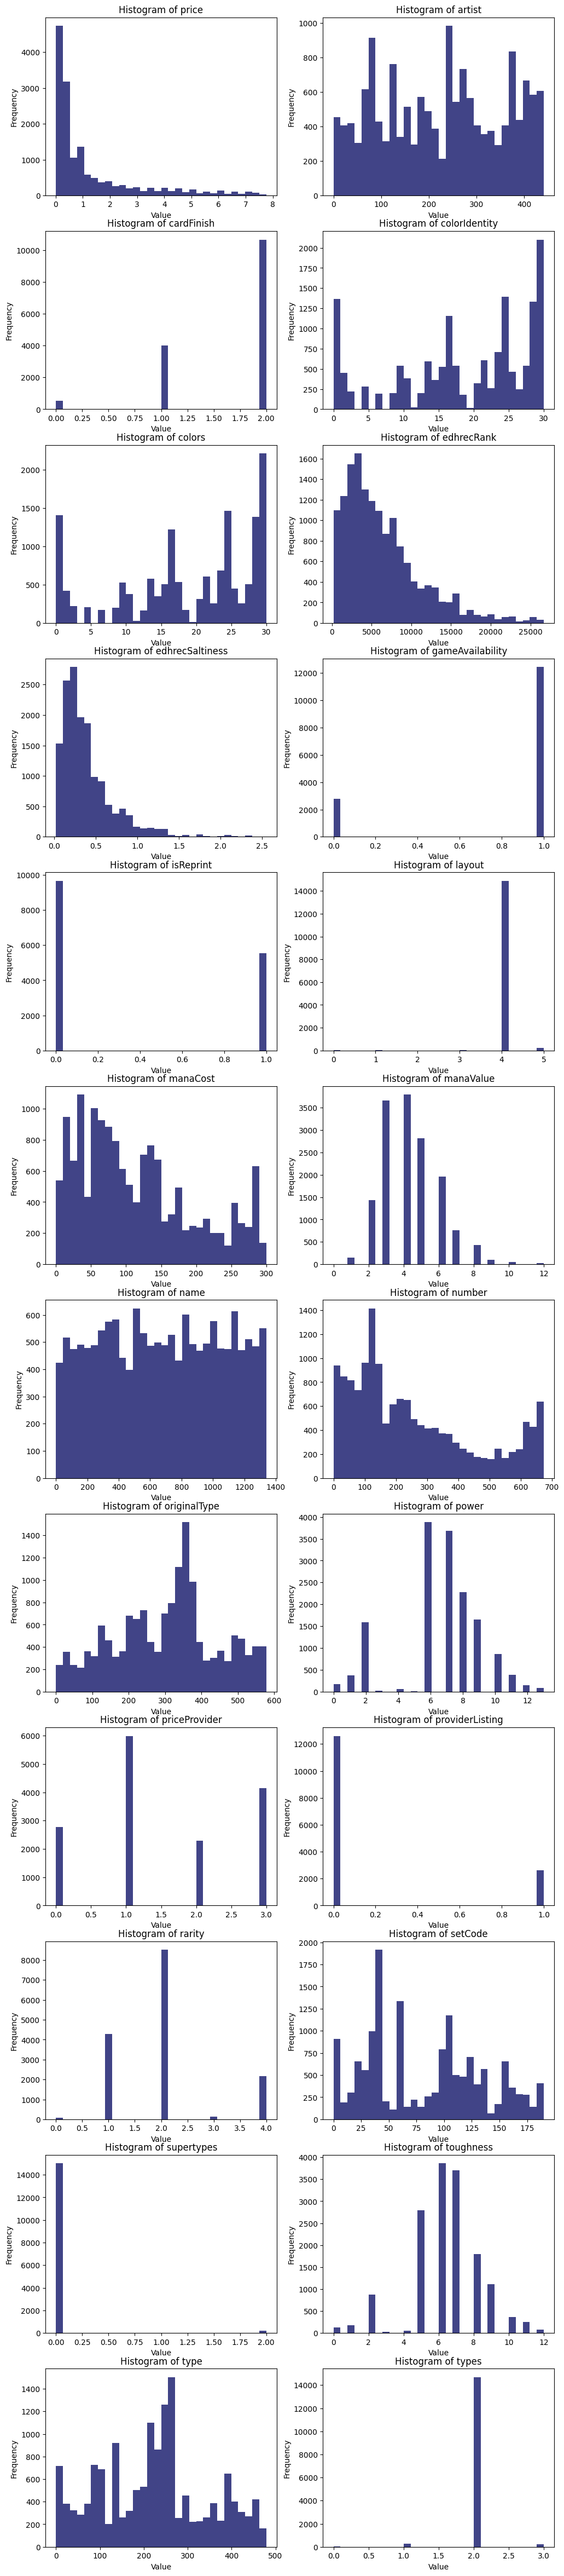

In [8]:
plot(data, "hist", bins=30)

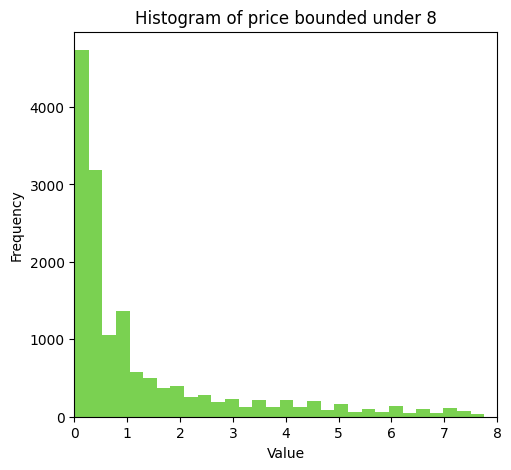

count    15214.000000
mean         1.274955
std          1.687801
min          0.010000
25%          0.200000
50%          0.490000
75%          1.570000
max          7.760000
Name: price, dtype: float64


In [9]:
plot(data[["price"]], "hist", plt.cm.viridis(0.8), bins=30, lim=8)
print(data['price'].describe())

In [10]:
# Correlations
def corr(data, dataset):
    """Plot correlation between variables in a dataframe
    Args:
        - data: dataframe
    """
    correlation_matrix = data.corr()
    
    # get price to be the first variable
    ordered = ['price'] + [col for col in correlation_matrix.columns if col != 'price']
    ordered_correlation_matrix = correlation_matrix.loc[ordered, ordered]

    plt.figure(figsize=(15,15))
    sns.heatmap(ordered_correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', square=True, linewidths=0.5)
    plt.title(f"{dataset} Correlation Heatmap of Variables")
    plt.savefig(f'../dataset/graphs/Correlation_{dataset}.png', format='png')
    plt.show()

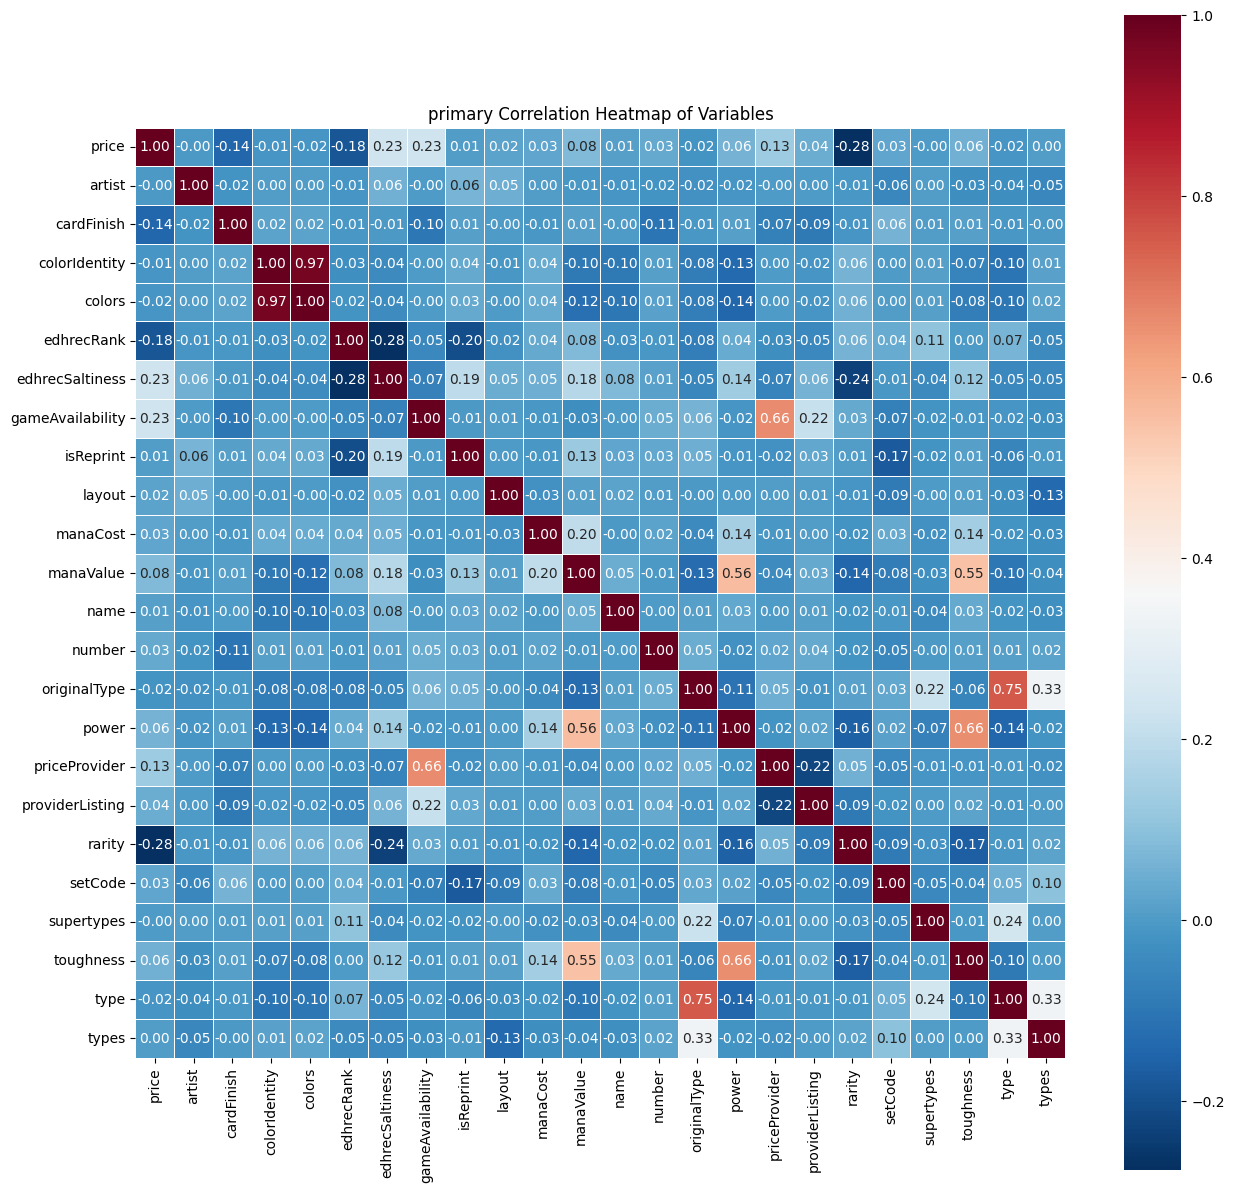

In [11]:
corr(data, dataset)


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = data.copy()
# Define a function to calculate VIF
def calculate_vif(df):
    # Adding a constant for intercept
    X = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF
vif_results = calculate_vif(df.drop(columns='price'))  # Drop the dependent variable
print("Variance Inflation Factor (VIF) results:")

# Identify features with high VIF
high_vif = vif_results[vif_results['VIF'] > 10]  # or 5 based on context
print("\nFeatures with high VIF (> 10):")
print(high_vif)

Variance Inflation Factor (VIF) results:

Features with high VIF (> 10):
         feature         VIF
0          const  450.867711
3  colorIdentity   20.310883
4         colors   20.384228


In [13]:
# drop primary colorIdentity
data = data.drop(columns='colorIdentity')

Original skewness: 1.8797424226421264
Square Root skewness: 0.9869019315131625
Inverse skewness: 2.897941980106822
Box-Cox skewness: 0.2672870971411354
Yeo-Johnson skewness: 0.2672871064070785


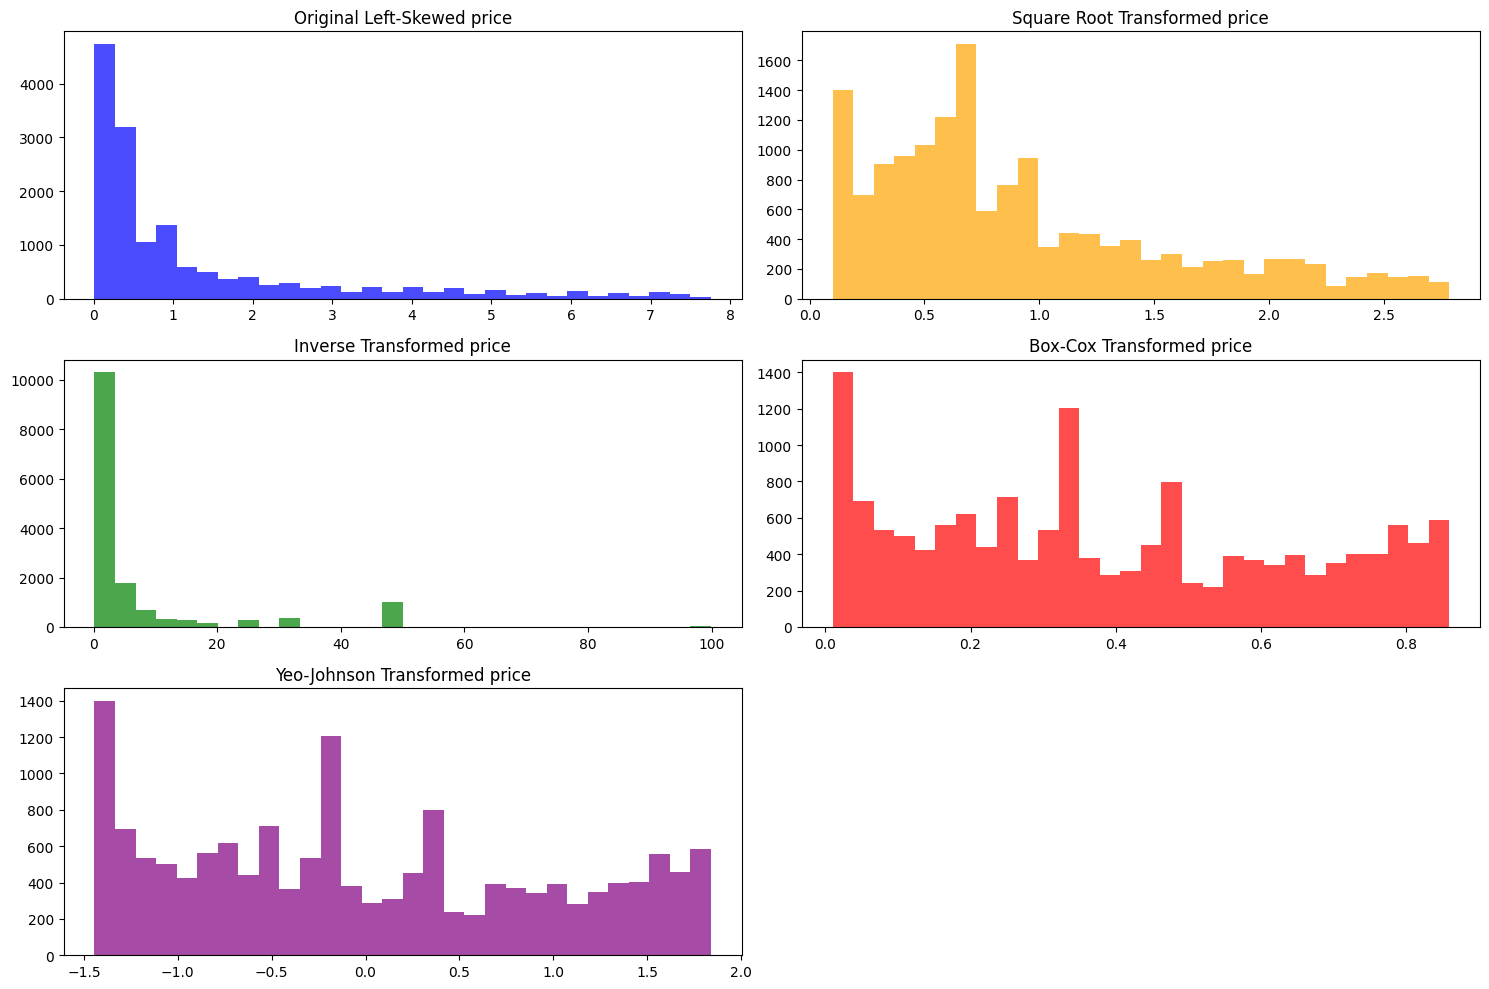

In [21]:
## transform data for normalcy 
df = data.copy()


import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer


def transforms (df, col):
    df['square_root_transformed'] = np.sqrt(df[col])
    df['inverse_transformed'] = 1 / (df[col] + 1e-5)  # Adding a small value to avoid division by zero
    df['boxcox_transformed'], _ = stats.boxcox(df[col] + 1)  # Adding 1 to handle zeros
    pt = PowerTransformer(method='yeo-johnson')
    df['yeo_transformed'] = pt.fit_transform(df[[col]])

    skewness = {
        'Original': df[col].skew(),
        'Square Root': df['square_root_transformed'].skew(),
        'Inverse': df['inverse_transformed'].skew(),
        'Box-Cox': df['boxcox_transformed'].skew(),
        'Yeo-Johnson': df['yeo_transformed'].skew(),
    }

    for transform, skew in skewness.items():
        print(f'{transform} skewness: {skew}')

    # Visualize the transformed data
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 2, 1)
    plt.hist(df[col], bins=30, alpha=0.7, color='blue')
    plt.title(f'Original Left-Skewed {col}')

    plt.subplot(3, 2, 2)
    plt.hist(df['square_root_transformed'], bins=30, alpha=0.7, color='orange')
    plt.title(f'Square Root Transformed {col}')

    plt.subplot(3, 2, 3)
    plt.hist(df['inverse_transformed'], bins=30, alpha=0.7, color='green')
    plt.title(f'Inverse Transformed {col}')

    plt.subplot(3, 2, 4)
    plt.hist(df['boxcox_transformed'], bins=30, alpha=0.7, color='red')
    plt.title(f'Box-Cox Transformed {col}')

    plt.subplot(3, 2, 5)
    plt.hist(df['yeo_transformed'], bins=30, alpha=0.7, color='purple')
    plt.title(f'Yeo-Johnson Transformed {col}')

    plt.tight_layout()
    plt.show()

    return df

price = transforms(df,'price')

Original skewness: 1.3436672116449409
Square Root skewness: 0.431495503769983
Inverse skewness: 4.935464842530545
Box-Cox skewness: -0.03143200332053425
Yeo-Johnson skewness: -0.03143199807916926


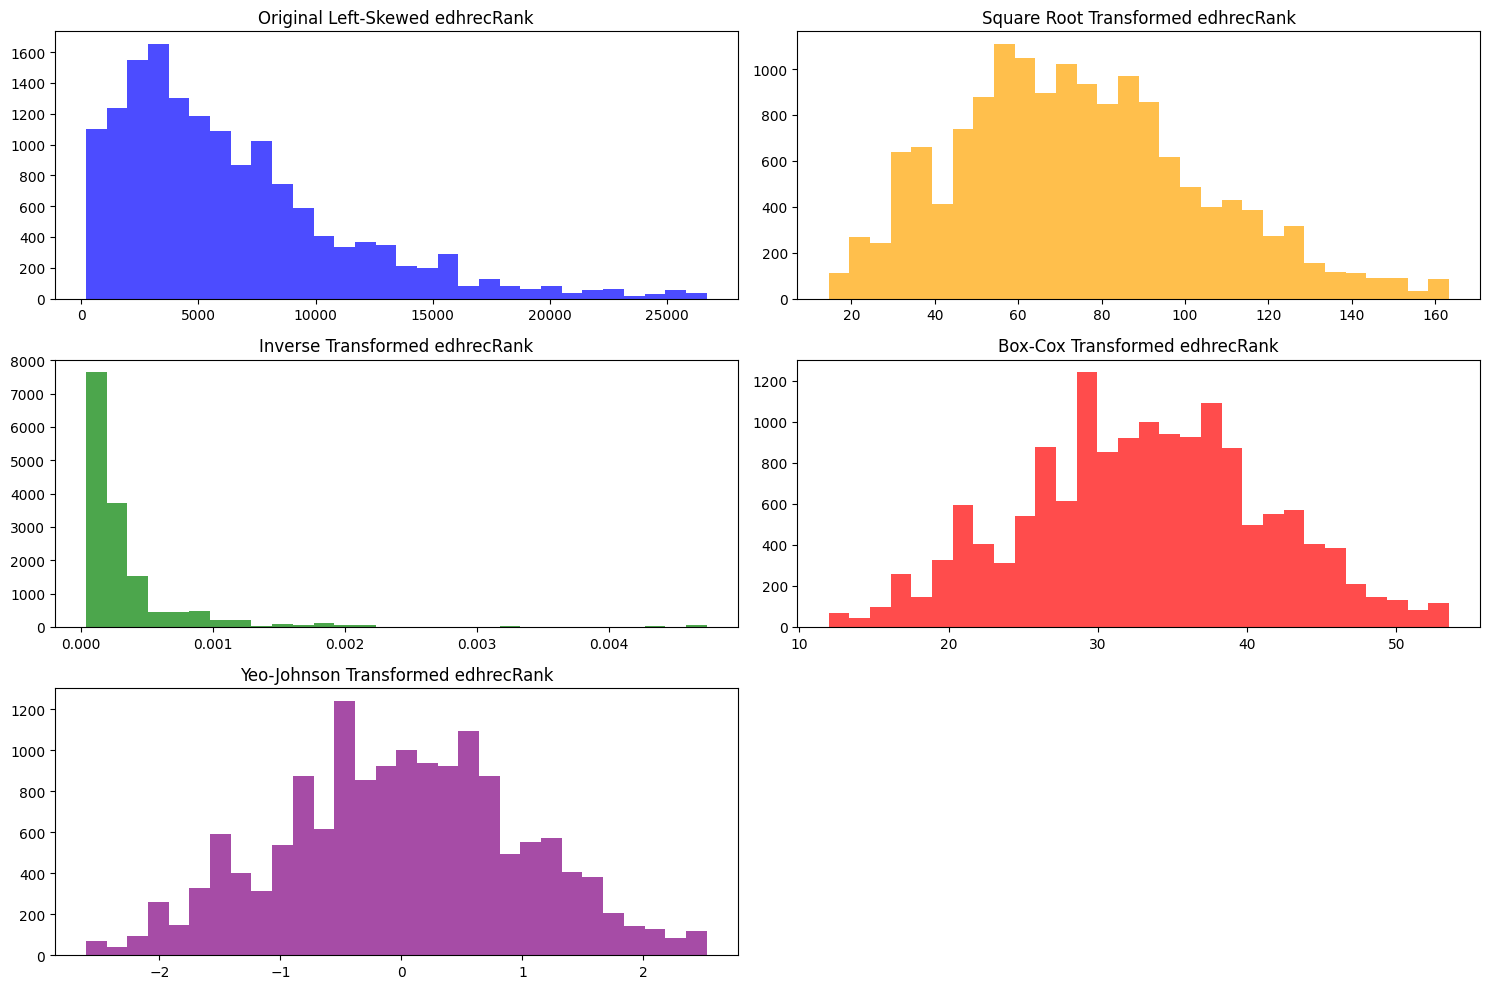

Original skewness: 2.076552905652101
Square Root skewness: 0.9077919528684577
Inverse skewness: 2.777608178060753
Box-Cox skewness: 0.14709876564098792
Yeo-Johnson skewness: 0.14709871974529082


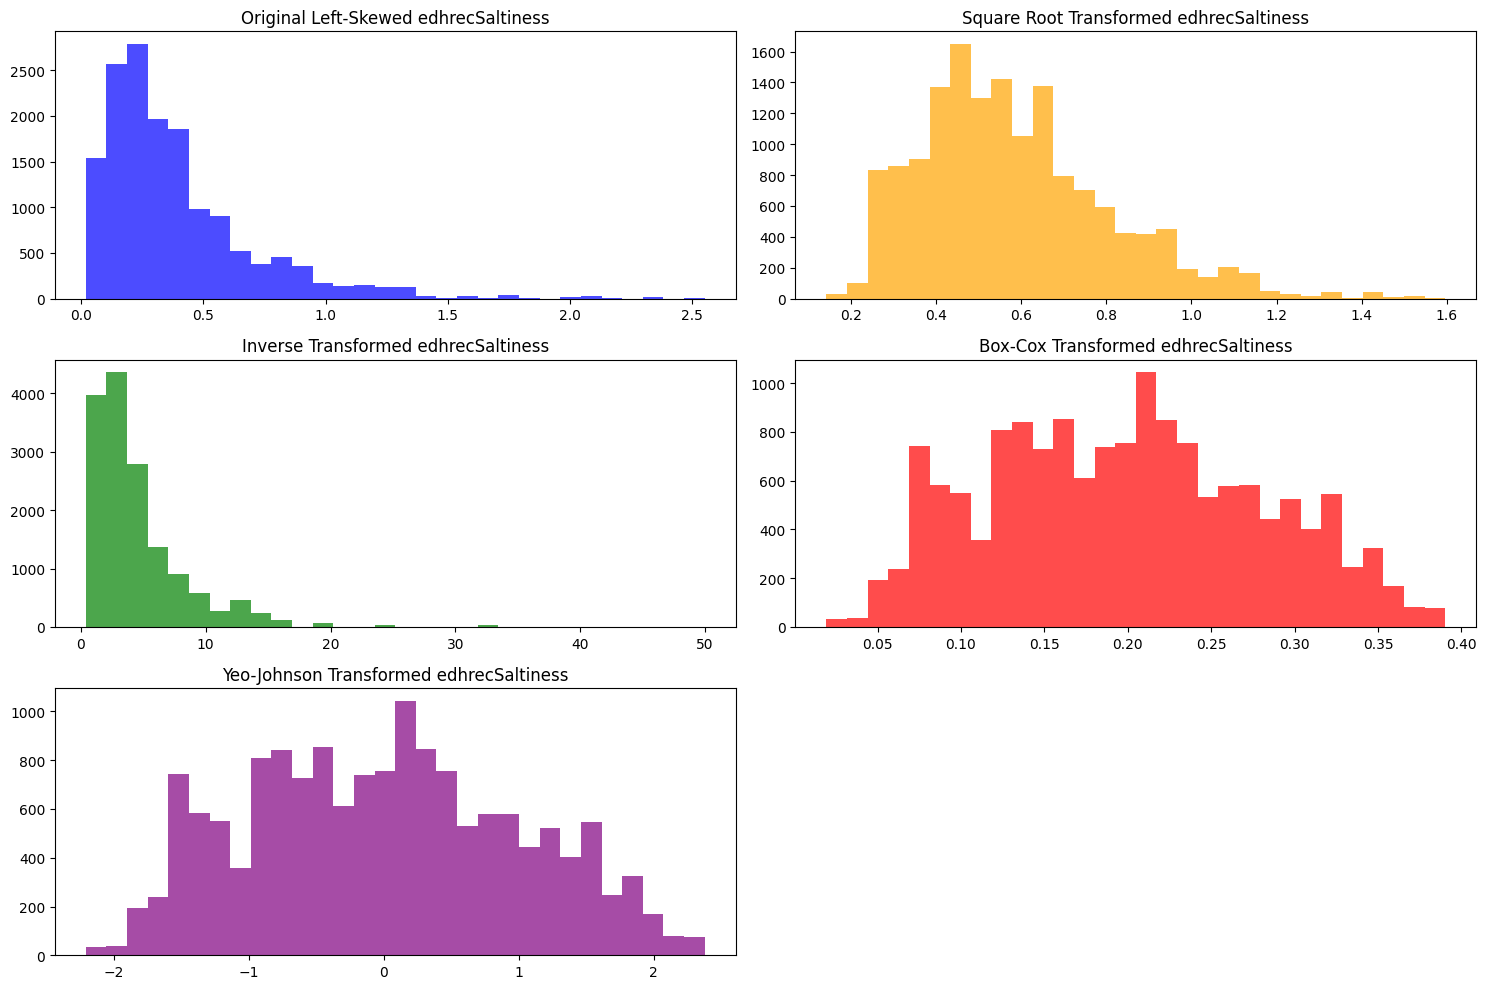

In [24]:
transform = data.copy()
transform['price'] = price['boxcox_transformed']

edr = transforms(df,'edhrecRank')
transform['price'] = edr['boxcox_transformed']

eds = transforms(df,'edhrecSaltiness')
transform['price'] = eds['boxcox_transformed']

In [26]:
# Initialize a results list
results = []

# Calculate t-scores and p-values for each independent variable
for col in data.columns:
    if col != 'price':
        t_stat, p_value = stats.ttest_ind(df[col], df['price'], equal_var=False)  # Welch's t-test
        results.append({'Variable': col, 'T-score': t_stat, 'P-value': p_value})

# Create a results DataFrame
results_df = pd.DataFrame(results)

print(f"Primary Dataset Results: \n{results_df.to_string(index=False)}")

Primary Dataset Results: 
        Variable    T-score       P-value
          artist 216.822599  0.000000e+00
      cardFinish  27.089676 1.704672e-158
          colors 214.102136  0.000000e+00
      edhrecRank 161.394553  0.000000e+00
 edhrecSaltiness -63.338320  0.000000e+00
gameAvailability -32.594882 4.997116e-226
       isReprint -63.939938  0.000000e+00
          layout 196.797219  0.000000e+00
        manaCost 172.520311  0.000000e+00
       manaValue 160.126938  0.000000e+00
            name 216.281241  0.000000e+00
          number 157.891695  0.000000e+00
    originalType 261.491856  0.000000e+00
           power 222.045356  0.000000e+00
   priceProvider  14.721119  7.443080e-49
 providerListing -78.676648  0.000000e+00
          rarity  46.393962  0.000000e+00
         setCode 191.189442  0.000000e+00
      supertypes -90.274842  0.000000e+00
       toughness 241.450764  0.000000e+00
            type 224.161196  0.000000e+00
           types  52.260535  0.000000e+00


In [27]:
# Initialize a results list
results = []

# Calculate t-scores and p-values for each independent variable
for col in transform.columns:
    if col != 'price':
        t_stat, p_value = stats.ttest_ind(df[col], df['price'], equal_var=False)  # Welch's t-test
        results.append({'Variable': col, 'T-score': t_stat, 'P-value': p_value})

# Create a results DataFrame
results_df = pd.DataFrame(results)

print(f"Primary Dataset Results: \n{results_df.to_string(index=False)}")

Primary Dataset Results: 
        Variable    T-score       P-value
          artist 216.822599  0.000000e+00
      cardFinish  27.089676 1.704672e-158
          colors 214.102136  0.000000e+00
      edhrecRank 161.394553  0.000000e+00
 edhrecSaltiness -63.338320  0.000000e+00
gameAvailability -32.594882 4.997116e-226
       isReprint -63.939938  0.000000e+00
          layout 196.797219  0.000000e+00
        manaCost 172.520311  0.000000e+00
       manaValue 160.126938  0.000000e+00
            name 216.281241  0.000000e+00
          number 157.891695  0.000000e+00
    originalType 261.491856  0.000000e+00
           power 222.045356  0.000000e+00
   priceProvider  14.721119  7.443080e-49
 providerListing -78.676648  0.000000e+00
          rarity  46.393962  0.000000e+00
         setCode 191.189442  0.000000e+00
      supertypes -90.274842  0.000000e+00
       toughness 241.450764  0.000000e+00
            type 224.161196  0.000000e+00
           types  52.260535  0.000000e+00


In [30]:
print(transform)

transform.to_csv('../dataset/transform_primary.csv', index = False)

          price  artist  cardFinish  colors  edhrecRank  edhrecSaltiness  \
0      0.077700     341           2      23     20330.0             0.09   
1      0.077700     341           1      23     20330.0             0.09   
2      0.077700     341           2      23     20330.0             0.09   
3      0.077700     341           2      23     20330.0             0.09   
4      0.077700     341           2      23     20330.0             0.09   
...         ...     ...         ...     ...         ...              ...   
15209  0.244063     274           2      16      5527.0             0.45   
15210  0.244063     274           1      16      5527.0             0.45   
15211  0.244063     274           2      16      5527.0             0.45   
15212  0.244063     274           1      16      5527.0             0.45   
15213  0.244063     274           2      16      5527.0             0.45   

       gameAvailability  isReprint  layout  manaCost  ...  originalType  \
0           